Berceley Deep RL course. Fall 2017
http://rll.berkeley.edu/deeprlcourse/
Homework 1

## Behavioral Cloning
1.  Run  behavioral  cloning  (BC)  and  report  results  on  two  other  tasks  –  one  task  where  a  behavioral
cloning agent achieves comparable performance to the expert, and one task where it does not.  When
providing  results,  report  the  mean  and  standard  deviation  of  the  return  over  multiple  rollouts  in  a
table, and state which task was used.  Be sure to set up a fair comparison, in terms of network size,
amount of data, and number of training iterations, and provide these details (and any others you feel
are appropriate) in the table caption.
1
2.  Experiment with one hyperparameter that affects the performance of the behavioral cloning agent, such
as the number of demonstrations, the number of training epochs, the variance of the expert policy, or
something that you come up with yourself.  For one of the tasks used in the previous question, show a
graph of how the BC agent’s performance varies with the value of this hyperparameter, and state the
hyperparameter and a brief rationale for why you chose it in the caption for the graph.

In [1]:
import gym
 
#env = gym.make('Hopper-v1')

In [2]:
import time
import math
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline


def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

### Feed forward nn

In [3]:
class FFN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2,output_size,dropout_rate = 0.3):
        super(FFN, self).__init__()
        self.dropout_rate = dropout_rate
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.drop1  = nn.Dropout(p = self.dropout_rate)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.drop2  = nn.Dropout(p = self.dropout_rate)
        self.fc3 = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        x = F.sigmoid(self.fc1(x))
        x = self.drop1(x)
        x = F.relu(self.fc2(x))
        x = self.drop2(x)
        x = self.fc3(x)
        return x.view(x.size(0), -1)
    
    def set_dropout_rate(self, p):
        self.dropout_rate = p
        


In [4]:
criterion = torch.nn.L1Loss()

# Training function
def train_ffn(states_tensor, actions_tensor,learning_rate):
    tmp_loss = 0
    
    ffn.zero_grad()

    output = ffn(states_tensor)               # Predict action
    loss = criterion(output, actions_tensor)  # Calculate error
    tmp_loss += loss.data[0]
    loss.backward()                              # Error backpropagation

    for p in ffn.parameters():                   # Update net's parameters
        p.data.add_(-learning_rate, p.grad.data)
    
    return output, tmp_loss 

In [5]:
#!/usr/bin/env python

"""
Code to load an expert policy and generate roll-out data for behavioral cloning.
Example usage:
    python run_expert.py experts/Humanoid-v1.pkl Humanoid-v1 --render \
            --num_rollouts 20

Author of this script and included expert policies: Jonathan Ho (hoj@openai.com)
"""

import pickle
import tensorflow as tf
import numpy as np
import tf_util
import gym
import load_policy
import pandas as pd

minibatch_size = 8

def learn_imitatation_learning(ffn, args):
    
    print('loading and building expert policy')
    target_policy_fn = load_policy.load_policy(args.expert_policy_file)
    print('loaded and built')

    with tf.Session():
        tf_util.initialize()

        import gym
        env = gym.make(args.envname)
        max_steps = args.max_timesteps or env.spec.timestep_limit

        returns = []
        observations = []
        actions = []
        for i in range(args.num_rollouts):
            #print('iter', i)
            obs = env.reset()
            done = False
            totalr = 0.
            steps = 0
            while not done:
                action = target_policy_fn(obs[None,:])
                observations.append(obs)
                actions.append(action)
                obs, r, done, _ = env.step(action)
                totalr += r
                steps += 1
                
                if args.render:
                    env.render()
                if steps % minibatch_size == 0: 
                    _, error = train_ffn(Variable(torch.Tensor(observations[-minibatch_size:])), 
                                         Variable(torch.Tensor(np.array(actions[-minibatch_size:])[:,0,:])),
                                         learning_rate
                                        )
                    #print("%i/%i, Error %f"%(steps, max_steps,error))
                    
                    
                if steps >= max_steps:
                    break
            returns.append(totalr)

#         print('returns', returns)
#         print('mean return', np.mean(returns))
#         print('std of return', np.std(returns))

#         expert_data = {'observations': np.array(observations),
#                        'actions': np.array(actions)}
        return returns,error
        

#Evaluate learned policy
def evaluate_imitation_learning(ffn, args):
    dropout_rate = ffn.dropout_rate
    ffn.dropout_rate = 0
    env = gym.make(args.envname)
    max_steps = args.max_timesteps or env.spec.timestep_limit

    returns = []
    observations = []
    actions = []
    for i in range(args.num_rollouts):
        #print('iter', i)
        obs = env.reset()
        done = False
        totalr = 0.
        steps = 0
        while not done:
            action = ffn(Variable(torch.Tensor(obs))).data.numpy()  
            observations.append(obs)
            actions.append(action)
            obs, r, done, _ = env.step(action)
            totalr += r
            steps += 1

            if args.render:
                env.render()

            if steps >= max_steps:
                break
            
        #print(totalr)
        returns.append(totalr)

#     print('returns', returns)
#     print('mean return', np.mean(returns))
#     print('std of return', np.std(returns))

#     expert_data = {'observations': np.array(observations),
#                    'actions': np.array(actions)}
        ffn.dropout_rate = dropout_rate
        return returns


In [6]:
! ls experts/

Ant-v1.pkl	    Hopper-v1.pkl    Reacher-v1.pkl
HalfCheetah-v1.pkl  Humanoid-v1.pkl  Walker2d-v1.pkl


### Train loop

In [7]:
learning_rate = 1e-2

envname = 'HalfCheetah-v1'
env = gym.make(envname)
#with gym.make(envname) as env:
state_shape = env.observation_space.shape[0]
actions_shape = env.action_space.shape[0]

print('Starting {} environment. State space dim (), action space dim {}.'.format(
    envname,
    state_shape,
    actions_shape)
     )

ffn = FFN(state_shape, 128, 64,actions_shape,dropout_rate = 0)

learn_args = pd.Series({
        'expert_policy_file':'experts/' + envname + '.pkl',
        'envname': envname,
        'max_timesteps': None,
        'num_rollouts':2,
        'render': False
    })


eval_args = pd.Series({
        'envname': envname,
        'max_timesteps': None,
        'num_rollouts':2,
        'render': False
    })

n_iter = 300

results = []
for i in range(n_iter):
    experts_returns, error = learn_imitatation_learning(ffn, learn_args)
    agent_returns   = evaluate_imitation_learning(ffn, eval_args)
    print(i, np.mean(experts_returns),np.mean(error), np.mean(agent_returns),np.std(agent_returns))
    results.append((np.mean(experts_returns),np.mean(error),np.mean(agent_returns),np.std(agent_returns)))


[2017-11-02 13:39:35,112] Making new env: HalfCheetah-v1


Starting HalfCheetah-v1 environment. State space dim (), action space dim 17.
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:39:38,236] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:39:38,263] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:39:38,308] Making new env: HalfCheetah-v1
[2017-11-02 13:39:54,108] Making new env: HalfCheetah-v1


0 4163.94359844 0.480108380318 -36.6919361499 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:40:00,166] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:40:00,193] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:40:00,246] Making new env: HalfCheetah-v1
[2017-11-02 13:40:17,032] Making new env: HalfCheetah-v1


1 4099.47938848 0.253719955683 1280.31803653 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:40:23,531] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:40:23,555] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:40:23,594] Making new env: HalfCheetah-v1
[2017-11-02 13:40:37,063] Making new env: HalfCheetah-v1


2 4117.66751774 0.310013979673 1597.1196019 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:40:42,410] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:40:42,431] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:40:42,479] Making new env: HalfCheetah-v1
[2017-11-02 13:40:55,375] Making new env: HalfCheetah-v1


3 4115.24368377 0.188581511378 1991.08038409 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:40:59,354] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:40:59,375] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:40:59,418] Making new env: HalfCheetah-v1
[2017-11-02 13:41:08,475] Making new env: HalfCheetah-v1


4 4140.66739086 0.157792821527 1977.40619814 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:41:13,250] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:41:13,261] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:41:13,302] Making new env: HalfCheetah-v1
[2017-11-02 13:41:22,563] Making new env: HalfCheetah-v1


5 4184.62903113 0.204993918538 1935.52236392 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:41:26,638] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:41:26,660] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:41:26,712] Making new env: HalfCheetah-v1
[2017-11-02 13:41:35,837] Making new env: HalfCheetah-v1


6 4156.21732127 0.285839110613 2111.82526395 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:41:39,892] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:41:39,912] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:41:39,967] Making new env: HalfCheetah-v1
[2017-11-02 13:41:48,668] Making new env: HalfCheetah-v1


7 4139.52808359 0.171909794211 1830.10938009 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:41:52,602] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:41:52,628] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:41:52,678] Making new env: HalfCheetah-v1
[2017-11-02 13:42:02,069] Making new env: HalfCheetah-v1


8 4091.3885944 0.223125457764 1664.78832965 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:42:06,208] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:42:06,225] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:42:06,284] Making new env: HalfCheetah-v1
[2017-11-02 13:42:15,442] Making new env: HalfCheetah-v1


9 4273.68606867 0.195564880967 2004.24173826 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:42:19,502] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:42:19,530] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:42:19,600] Making new env: HalfCheetah-v1
[2017-11-02 13:42:28,987] Making new env: HalfCheetah-v1


10 4210.28488448 0.213507354259 2249.44509586 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:42:32,940] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:42:32,965] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:42:33,034] Making new env: HalfCheetah-v1
[2017-11-02 13:42:42,088] Making new env: HalfCheetah-v1


11 4085.98564971 0.202043429017 1813.08459045 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:42:46,006] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:42:46,029] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:42:46,099] Making new env: HalfCheetah-v1
[2017-11-02 13:42:55,163] Making new env: HalfCheetah-v1


12 4132.06907101 0.199140295386 1539.56479169 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:42:59,199] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:42:59,223] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:42:59,293] Making new env: HalfCheetah-v1
[2017-11-02 13:43:08,299] Making new env: HalfCheetah-v1


13 4124.44508181 0.296041160822 1776.43698531 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:43:13,150] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:43:13,179] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:43:13,257] Making new env: HalfCheetah-v1
[2017-11-02 13:43:22,644] Making new env: HalfCheetah-v1


14 4157.82439353 0.174835145473 1829.24414399 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:43:26,534] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:43:26,558] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:43:26,637] Making new env: HalfCheetah-v1
[2017-11-02 13:43:35,511] Making new env: HalfCheetah-v1


15 4108.21889658 0.127921357751 1802.92750977 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:43:39,398] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:43:39,414] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:43:39,504] Making new env: HalfCheetah-v1
[2017-11-02 13:43:48,248] Making new env: HalfCheetah-v1


16 4098.73797576 0.233824670315 1897.14130076 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:43:52,106] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:43:52,123] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:43:52,210] Making new env: HalfCheetah-v1
[2017-11-02 13:44:01,403] Making new env: HalfCheetah-v1


17 4122.10968891 0.227245911956 1875.46211505 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:44:05,239] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:44:05,261] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:44:05,355] Making new env: HalfCheetah-v1
[2017-11-02 13:44:14,206] Making new env: HalfCheetah-v1


18 4145.48702101 0.239468440413 2035.0869111 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:44:18,318] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:44:18,335] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:44:18,430] Making new env: HalfCheetah-v1
[2017-11-02 13:44:27,285] Making new env: HalfCheetah-v1


19 4112.3752809 0.166439518332 1917.65895539 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:44:31,181] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:44:31,199] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:44:31,316] Making new env: HalfCheetah-v1
[2017-11-02 13:44:40,025] Making new env: HalfCheetah-v1


20 4014.76698184 0.477076739073 1852.5052381 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:44:43,922] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:44:43,941] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:44:44,044] Making new env: HalfCheetah-v1
[2017-11-02 13:44:52,823] Making new env: HalfCheetah-v1


21 4172.68003447 0.339572906494 1992.28919263 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:44:56,922] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:44:56,937] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:44:57,043] Making new env: HalfCheetah-v1
[2017-11-02 13:45:05,858] Making new env: HalfCheetah-v1


22 4181.07474763 0.127148091793 1950.82980116 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:45:09,978] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:45:09,990] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:45:10,113] Making new env: HalfCheetah-v1
[2017-11-02 13:45:20,661] Making new env: HalfCheetah-v1


23 4211.53936849 0.172476008534 2373.69108694 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:45:24,562] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:45:24,587] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:45:24,705] Making new env: HalfCheetah-v1
[2017-11-02 13:45:37,864] Making new env: HalfCheetah-v1


24 4229.37067021 0.165588125587 2119.47409899 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:45:43,311] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:45:43,335] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:45:43,473] Making new env: HalfCheetah-v1
[2017-11-02 13:45:55,484] Making new env: HalfCheetah-v1


25 4193.64121034 0.242151841521 1983.9448794 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:46:00,619] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:46:00,642] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:46:00,790] Making new env: HalfCheetah-v1
[2017-11-02 13:46:12,832] Making new env: HalfCheetah-v1


26 4128.96941567 0.159355357289 2401.37364116 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:46:18,162] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:46:18,183] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:46:18,343] Making new env: HalfCheetah-v1
[2017-11-02 13:46:30,461] Making new env: HalfCheetah-v1


27 4161.17464192 0.18653267622 2044.81710048 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:46:35,650] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:46:35,669] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:46:35,838] Making new env: HalfCheetah-v1
[2017-11-02 13:46:48,379] Making new env: HalfCheetah-v1


28 4195.50759233 0.246904715896 2034.893509 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:46:53,593] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:46:53,621] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:46:53,816] Making new env: HalfCheetah-v1
[2017-11-02 13:47:05,845] Making new env: HalfCheetah-v1


29 4155.05935457 0.0835069715977 1534.23153256 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:47:11,178] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:47:11,187] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:47:11,369] Making new env: HalfCheetah-v1
[2017-11-02 13:47:24,761] Making new env: HalfCheetah-v1


30 4093.08608932 0.223605394363 2115.60527128 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:47:29,938] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:47:29,958] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:47:30,124] Making new env: HalfCheetah-v1
[2017-11-02 13:47:42,044] Making new env: HalfCheetah-v1


31 4121.24118913 0.0771396160126 1914.83406155 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:47:47,350] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:47:47,382] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:47:47,550] Making new env: HalfCheetah-v1
[2017-11-02 13:47:59,609] Making new env: HalfCheetah-v1


32 4168.48070857 0.130710840225 2240.34483853 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:48:04,312] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:48:04,332] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:48:04,480] Making new env: HalfCheetah-v1
[2017-11-02 13:48:13,524] Making new env: HalfCheetah-v1


33 4121.67639432 0.135231480002 2227.82936602 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:48:17,767] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:48:17,786] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:48:17,927] Making new env: HalfCheetah-v1
[2017-11-02 13:48:27,021] Making new env: HalfCheetah-v1


34 4111.86268488 0.10690049082 1815.6765085 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:48:31,136] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:48:31,158] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:48:31,313] Making new env: HalfCheetah-v1
[2017-11-02 13:48:40,384] Making new env: HalfCheetah-v1


35 4108.22163499 0.118019901216 2189.3618261 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:48:44,612] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:48:44,637] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:48:44,787] Making new env: HalfCheetah-v1
[2017-11-02 13:48:53,818] Making new env: HalfCheetah-v1


36 4101.58735482 0.129485264421 2148.6679328 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:48:57,747] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:48:57,770] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:48:57,927] Making new env: HalfCheetah-v1
[2017-11-02 13:49:06,999] Making new env: HalfCheetah-v1


37 4202.0840098 0.108805716038 2164.27078674 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:49:10,410] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:49:10,432] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:49:10,583] Making new env: HalfCheetah-v1
[2017-11-02 13:49:21,277] Making new env: HalfCheetah-v1


38 4136.73281836 0.204122230411 1761.63549308 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:49:24,758] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:49:24,767] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:49:24,885] Making new env: HalfCheetah-v1
[2017-11-02 13:49:34,824] Making new env: HalfCheetah-v1


39 4188.58829062 0.0954686403275 2252.21920175 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:49:38,366] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:49:38,382] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:49:38,515] Making new env: HalfCheetah-v1
[2017-11-02 13:49:46,289] Making new env: HalfCheetah-v1


40 4069.52549435 0.209275171161 2136.94917287 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:49:49,706] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:49:49,723] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:49:49,886] Making new env: HalfCheetah-v1
[2017-11-02 13:49:57,513] Making new env: HalfCheetah-v1


41 4123.35133512 0.139247834682 2696.05627488 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:50:00,999] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:50:01,015] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:50:01,182] Making new env: HalfCheetah-v1
[2017-11-02 13:50:08,788] Making new env: HalfCheetah-v1


42 4156.967679 0.132727965713 1929.07813295 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:50:12,239] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:50:12,258] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:50:12,390] Making new env: HalfCheetah-v1
[2017-11-02 13:50:20,368] Making new env: HalfCheetah-v1


43 4200.62507091 0.103245414793 2576.74857676 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:50:23,806] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:50:23,825] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:50:24,030] Making new env: HalfCheetah-v1
[2017-11-02 13:50:31,656] Making new env: HalfCheetah-v1


44 4155.05163571 0.0715138986707 2443.06425061 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:50:35,068] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:50:35,085] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:50:35,221] Making new env: HalfCheetah-v1
[2017-11-02 13:50:42,684] Making new env: HalfCheetah-v1


45 4128.64780162 0.16950045526 2228.62677732 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:50:46,190] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:50:46,209] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:50:46,371] Making new env: HalfCheetah-v1
[2017-11-02 13:50:54,116] Making new env: HalfCheetah-v1


46 4168.75886411 0.163350686431 2167.55842271 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:50:57,526] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:50:57,543] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:50:57,742] Making new env: HalfCheetah-v1
[2017-11-02 13:51:05,496] Making new env: HalfCheetah-v1


47 4152.15808172 0.171164929867 2579.58869557 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:51:08,806] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:51:08,822] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:51:09,012] Making new env: HalfCheetah-v1
[2017-11-02 13:51:17,315] Making new env: HalfCheetah-v1


48 4179.63906324 0.161095902324 2458.39742782 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:51:20,770] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:51:20,788] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:51:20,983] Making new env: HalfCheetah-v1
[2017-11-02 13:51:28,620] Making new env: HalfCheetah-v1


49 4256.45355518 0.116408936679 2521.62801308 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:51:32,015] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:51:32,029] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:51:32,230] Making new env: HalfCheetah-v1
[2017-11-02 13:51:39,793] Making new env: HalfCheetah-v1


50 4232.00496318 0.112598218024 2284.63176875 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:51:43,284] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:51:43,298] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:51:43,462] Making new env: HalfCheetah-v1
[2017-11-02 13:51:51,036] Making new env: HalfCheetah-v1


51 4092.38744618 0.121990002692 2983.10927818 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:51:54,382] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:51:54,397] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:51:54,632] Making new env: HalfCheetah-v1
[2017-11-02 13:52:02,391] Making new env: HalfCheetah-v1


52 4179.54677387 0.177749872208 2519.80408226 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:52:05,865] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:52:05,886] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:52:06,098] Making new env: HalfCheetah-v1
[2017-11-02 13:52:13,713] Making new env: HalfCheetah-v1


53 4153.66553437 0.221398517489 2234.06239005 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:52:17,536] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:52:17,550] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:52:17,716] Making new env: HalfCheetah-v1
[2017-11-02 13:52:25,365] Making new env: HalfCheetah-v1


54 4156.17185546 0.108884193003 2817.8496369 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:52:28,814] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:52:28,832] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:52:29,069] Making new env: HalfCheetah-v1
[2017-11-02 13:52:38,425] Making new env: HalfCheetah-v1


55 4115.56786774 0.0791488140821 2630.52636797 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:52:43,218] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:52:43,232] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:52:43,447] Making new env: HalfCheetah-v1
[2017-11-02 13:52:52,319] Making new env: HalfCheetah-v1


56 4159.38515321 0.112825788558 1802.96885462 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:52:55,902] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:52:55,920] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:52:56,127] Making new env: HalfCheetah-v1
[2017-11-02 13:53:04,188] Making new env: HalfCheetah-v1


57 4093.59772582 0.100139886141 2269.13408965 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:53:07,875] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:53:07,895] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:53:08,145] Making new env: HalfCheetah-v1
[2017-11-02 13:53:16,757] Making new env: HalfCheetah-v1


58 4111.77544423 0.497804492712 2556.88530066 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:53:20,166] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:53:20,185] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:53:20,457] Making new env: HalfCheetah-v1
[2017-11-02 13:53:28,309] Making new env: HalfCheetah-v1


59 4183.11103194 0.117920428514 2329.59163355 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:53:31,808] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:53:31,825] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:53:32,049] Making new env: HalfCheetah-v1
[2017-11-02 13:53:39,967] Making new env: HalfCheetah-v1


60 4134.88338946 0.146628379822 2613.85313951 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:53:43,536] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:53:43,557] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:53:43,745] Making new env: HalfCheetah-v1
[2017-11-02 13:53:51,569] Making new env: HalfCheetah-v1


61 4061.49414881 0.0711329206824 2582.81967561 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:53:55,330] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:53:55,351] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:53:55,630] Making new env: HalfCheetah-v1
[2017-11-02 13:54:03,601] Making new env: HalfCheetah-v1


62 4206.48696378 0.0627879425883 2714.18625797 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:54:07,207] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:54:07,224] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:54:07,472] Making new env: HalfCheetah-v1
[2017-11-02 13:54:15,349] Making new env: HalfCheetah-v1


63 4044.16821053 0.100022949278 2534.96711867 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:54:19,664] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:54:19,680] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:54:19,946] Making new env: HalfCheetah-v1
[2017-11-02 13:54:27,858] Making new env: HalfCheetah-v1


64 4151.0292314 0.137991800904 2605.62328868 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:54:31,432] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:54:31,450] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:54:31,652] Making new env: HalfCheetah-v1
[2017-11-02 13:54:39,560] Making new env: HalfCheetah-v1


65 4097.66365269 0.0749237015843 2563.90508988 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:54:43,167] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:54:43,189] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:54:43,409] Making new env: HalfCheetah-v1
[2017-11-02 13:54:51,307] Making new env: HalfCheetah-v1


66 4027.75149392 0.140474453568 2484.79009794 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:54:54,808] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:54:54,825] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:54:55,114] Making new env: HalfCheetah-v1
[2017-11-02 13:55:03,044] Making new env: HalfCheetah-v1


67 4170.46297754 0.197091445327 2773.12377369 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:55:06,704] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:55:06,726] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:55:06,931] Making new env: HalfCheetah-v1
[2017-11-02 13:55:15,620] Making new env: HalfCheetah-v1


68 4061.44464877 0.135509416461 2634.95422159 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:55:19,286] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:55:19,305] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:55:19,595] Making new env: HalfCheetah-v1
[2017-11-02 13:55:27,536] Making new env: HalfCheetah-v1


69 4123.19457273 0.184130236506 2994.09935261 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:55:31,148] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:55:31,166] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:55:31,404] Making new env: HalfCheetah-v1
[2017-11-02 13:55:39,471] Making new env: HalfCheetah-v1


70 4095.94756511 0.104907073081 2934.79835911 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:55:43,260] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:55:43,275] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:55:43,556] Making new env: HalfCheetah-v1
[2017-11-02 13:55:51,659] Making new env: HalfCheetah-v1


71 4206.17566637 0.151517689228 2505.55227084 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:55:55,256] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:55:55,274] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:55:55,544] Making new env: HalfCheetah-v1
[2017-11-02 13:56:03,718] Making new env: HalfCheetah-v1


72 4156.46311428 0.0756680592895 2855.61249245 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:56:07,244] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:56:07,264] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:56:07,564] Making new env: HalfCheetah-v1
[2017-11-02 13:56:15,357] Making new env: HalfCheetah-v1


73 4175.45489837 0.0998532250524 2615.3225652 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:56:19,552] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:56:19,579] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:56:19,887] Making new env: HalfCheetah-v1
[2017-11-02 13:56:28,021] Making new env: HalfCheetah-v1


74 4079.15434347 0.174692675471 2832.7203917 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:56:31,487] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:56:31,501] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:56:31,757] Making new env: HalfCheetah-v1
[2017-11-02 13:56:39,833] Making new env: HalfCheetah-v1


75 4098.90331774 0.0512390770018 2707.31397865 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:56:43,445] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:56:43,459] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:56:43,702] Making new env: HalfCheetah-v1
[2017-11-02 13:56:51,698] Making new env: HalfCheetah-v1


76 4204.39117827 0.0639415085316 2688.45627164 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:56:55,304] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:56:55,318] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:56:55,573] Making new env: HalfCheetah-v1
[2017-11-02 13:57:03,861] Making new env: HalfCheetah-v1


77 4097.24273322 0.0631015151739 2277.70698865 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:57:07,483] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:57:07,502] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:57:07,803] Making new env: HalfCheetah-v1
[2017-11-02 13:57:16,329] Making new env: HalfCheetah-v1


78 4036.15626875 0.202670872211 2923.99830221 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:57:19,899] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:57:19,917] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:57:20,195] Making new env: HalfCheetah-v1
[2017-11-02 13:57:28,051] Making new env: HalfCheetah-v1


79 4094.28362096 0.0676612481475 2430.24500233 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:57:31,522] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:57:31,545] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:57:31,870] Making new env: HalfCheetah-v1
[2017-11-02 13:57:39,541] Making new env: HalfCheetah-v1


80 4180.73682315 0.115766994655 2793.14803756 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:57:43,156] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:57:43,174] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:57:43,454] Making new env: HalfCheetah-v1
[2017-11-02 13:57:51,481] Making new env: HalfCheetah-v1


81 4086.85222167 0.1844509691 2449.48293358 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:57:54,973] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:57:54,997] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:57:55,246] Making new env: HalfCheetah-v1
[2017-11-02 13:58:03,454] Making new env: HalfCheetah-v1


82 4248.99636508 0.116907216609 2423.64849854 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:58:06,999] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:58:07,017] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:58:07,341] Making new env: HalfCheetah-v1
[2017-11-02 13:58:15,049] Making new env: HalfCheetah-v1


83 4093.12987074 0.092452712357 2713.67103028 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:58:19,234] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:58:19,254] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:58:19,687] Making new env: HalfCheetah-v1
[2017-11-02 13:58:27,789] Making new env: HalfCheetah-v1


84 4203.77586437 0.259938687086 2588.69195978 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:58:31,196] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:58:31,220] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:58:31,563] Making new env: HalfCheetah-v1
[2017-11-02 13:58:39,282] Making new env: HalfCheetah-v1


85 4144.83758062 0.0795082524419 3010.54796755 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:58:42,755] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:58:42,773] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:58:43,052] Making new env: HalfCheetah-v1
[2017-11-02 13:58:50,887] Making new env: HalfCheetah-v1


86 4144.20243355 0.0509628467262 2817.47203206 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:58:54,524] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:58:54,545] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:58:54,873] Making new env: HalfCheetah-v1
[2017-11-02 13:59:02,613] Making new env: HalfCheetah-v1


87 4132.29375176 0.112713076174 3184.03943064 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:59:06,122] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:59:06,137] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:59:06,415] Making new env: HalfCheetah-v1
[2017-11-02 13:59:15,122] Making new env: HalfCheetah-v1


88 4111.02685022 0.21074230969 2960.01800754 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:59:18,671] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:59:18,687] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:59:19,018] Making new env: HalfCheetah-v1
[2017-11-02 13:59:26,948] Making new env: HalfCheetah-v1


89 4028.36000076 0.0833430662751 2171.5501344 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:59:30,595] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:59:30,610] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:59:30,918] Making new env: HalfCheetah-v1
[2017-11-02 13:59:38,694] Making new env: HalfCheetah-v1


90 4130.53781596 0.0752073526382 2782.25711053 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:59:42,281] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:59:42,295] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:59:42,644] Making new env: HalfCheetah-v1
[2017-11-02 13:59:50,540] Making new env: HalfCheetah-v1


91 4169.05608286 0.142480656505 2517.44687943 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:59:54,528] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:59:54,546] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:59:54,828] Making new env: HalfCheetah-v1
[2017-11-02 14:00:02,781] Making new env: HalfCheetah-v1


92 4134.12984598 0.147638782859 2912.93522823 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 14:00:06,247] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 14:00:06,268] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 14:00:06,654] Making new env: HalfCheetah-v1
[2017-11-02 14:00:14,508] Making new env: HalfCheetah-v1


93 4151.90911872 0.170195221901 3120.87609201 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 14:00:18,309] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 14:00:18,317] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 14:00:18,776] Making new env: HalfCheetah-v1
[2017-11-02 14:00:26,833] Making new env: HalfCheetah-v1


94 4122.78881659 0.153532639146 2847.92812105 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 14:00:30,371] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 14:00:30,384] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 14:00:30,708] Making new env: HalfCheetah-v1
[2017-11-02 14:00:38,457] Making new env: HalfCheetah-v1


95 4180.56668201 0.057341683656 3253.41428752 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 14:00:41,867] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 14:00:41,889] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 14:00:42,251] Making new env: HalfCheetah-v1
[2017-11-02 14:00:49,929] Making new env: HalfCheetah-v1


96 4105.70478632 0.11609724164 2659.45229843 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 14:00:53,404] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 14:00:53,422] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 14:00:53,814] Making new env: HalfCheetah-v1
[2017-11-02 14:01:01,877] Making new env: HalfCheetah-v1


97 4190.14578674 0.0850063934922 3038.82073984 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 14:01:05,355] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 14:01:05,373] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 14:01:05,690] Making new env: HalfCheetah-v1
[2017-11-02 14:01:14,408] Making new env: HalfCheetah-v1


98 4176.31870799 0.0469850338995 2791.10173229 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 14:01:18,261] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 14:01:18,274] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 14:01:18,682] Making new env: HalfCheetah-v1
[2017-11-02 14:01:26,664] Making new env: HalfCheetah-v1


99 4137.07108094 0.122789554298 3032.49746492 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 14:01:30,248] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 14:01:30,265] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 14:01:30,668] Making new env: HalfCheetah-v1
[2017-11-02 14:01:38,470] Making new env: HalfCheetah-v1


100 4131.47162721 0.114498205483 2176.79106218 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 14:01:42,113] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 14:01:42,130] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 14:01:42,488] Making new env: HalfCheetah-v1
[2017-11-02 14:01:50,392] Making new env: HalfCheetah-v1


101 4231.89896191 0.0896559432149 2553.70445683 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 14:01:53,927] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 14:01:53,948] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 14:01:54,254] Making new env: HalfCheetah-v1
[2017-11-02 14:02:02,426] Making new env: HalfCheetah-v1


102 4165.2428151 0.0601442754269 3018.13618712 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 14:02:05,998] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 14:02:06,015] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 14:02:06,431] Making new env: HalfCheetah-v1
[2017-11-02 14:02:14,042] Making new env: HalfCheetah-v1


103 4055.98184565 0.0779087617993 2911.44364325 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 14:02:17,888] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 14:02:17,900] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 14:02:18,419] Making new env: HalfCheetah-v1
[2017-11-02 14:02:26,741] Making new env: HalfCheetah-v1


104 4115.67391143 0.080019377172 2889.00492878 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 14:02:30,409] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 14:02:30,424] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 14:02:30,828] Making new env: HalfCheetah-v1
[2017-11-02 14:02:38,602] Making new env: HalfCheetah-v1


105 4097.35211509 0.0546575002372 2530.02043604 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 14:02:42,109] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 14:02:42,125] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 14:02:42,564] Making new env: HalfCheetah-v1
[2017-11-02 14:02:50,433] Making new env: HalfCheetah-v1


106 4176.14270466 0.131846234202 2878.09185223 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 14:02:54,058] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 14:02:54,083] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 14:02:54,530] Making new env: HalfCheetah-v1
[2017-11-02 14:03:02,725] Making new env: HalfCheetah-v1


107 4111.47221069 0.0679330527782 2901.36374485 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 14:03:06,267] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 14:03:06,288] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 14:03:06,656] Making new env: HalfCheetah-v1
[2017-11-02 14:03:15,459] Making new env: HalfCheetah-v1


108 4094.86922174 0.0612181611359 2495.31345756 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 14:03:19,039] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 14:03:19,052] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 14:03:19,462] Making new env: HalfCheetah-v1
[2017-11-02 14:03:27,321] Making new env: HalfCheetah-v1


109 4190.8958988 0.167265057564 2843.01219748 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 14:03:30,919] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 14:03:30,935] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 14:03:31,290] Making new env: HalfCheetah-v1
[2017-11-02 14:03:38,908] Making new env: HalfCheetah-v1


110 4165.78215206 0.184629619122 3169.56159867 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 14:03:42,467] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 14:03:42,487] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 14:03:42,919] Making new env: HalfCheetah-v1
[2017-11-02 14:03:50,622] Making new env: HalfCheetah-v1


111 4093.9869877 0.13413490355 2722.92643635 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 14:03:54,340] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 14:03:54,360] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 14:03:54,848] Making new env: HalfCheetah-v1
[2017-11-02 14:04:02,812] Making new env: HalfCheetah-v1


112 4043.19161783 0.0886621698737 2482.54324112 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 14:04:06,518] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 14:04:06,540] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 14:04:06,919] Making new env: HalfCheetah-v1
[2017-11-02 14:04:14,855] Making new env: HalfCheetah-v1


113 4121.86189169 0.145079016685 2907.9633667 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 14:04:19,088] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 14:04:19,106] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 14:04:19,694] Making new env: HalfCheetah-v1
[2017-11-02 14:04:27,591] Making new env: HalfCheetah-v1


114 4112.13501061 0.113470196724 2592.1130061 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 14:04:31,161] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 14:04:31,178] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 14:04:31,665] Making new env: HalfCheetah-v1
[2017-11-02 14:04:39,798] Making new env: HalfCheetah-v1


115 4147.80708838 0.0892230197787 2494.05730721 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 14:04:43,398] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 14:04:43,416] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 14:04:43,904] Making new env: HalfCheetah-v1
[2017-11-02 14:04:51,601] Making new env: HalfCheetah-v1


116 4269.72289401 0.0903809666634 3474.87416727 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 14:04:55,275] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 14:04:55,296] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 14:04:55,813] Making new env: HalfCheetah-v1
[2017-11-02 14:05:03,852] Making new env: HalfCheetah-v1


117 4266.0732276 0.0779732167721 2748.15667185 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 14:05:07,459] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 14:05:07,477] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 14:05:07,889] Making new env: HalfCheetah-v1
[2017-11-02 14:05:16,923] Making new env: HalfCheetah-v1


118 4204.99254245 0.166997745633 2773.05962578 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 14:05:20,407] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 14:05:20,434] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 14:05:20,890] Making new env: HalfCheetah-v1
[2017-11-02 14:05:28,804] Making new env: HalfCheetah-v1


119 4122.12954237 0.0759608373046 2705.00249898 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 14:05:32,389] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 14:05:32,415] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 14:05:32,891] Making new env: HalfCheetah-v1
[2017-11-02 14:05:40,585] Making new env: HalfCheetah-v1


120 4200.50215289 0.150010973215 2895.48537905 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 14:05:44,277] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 14:05:44,297] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 14:05:44,809] Making new env: HalfCheetah-v1
[2017-11-02 14:05:52,833] Making new env: HalfCheetah-v1


121 4245.07076151 0.102934539318 3094.3844893 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 14:05:56,466] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 14:05:56,488] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 14:05:56,971] Making new env: HalfCheetah-v1
[2017-11-02 14:06:05,096] Making new env: HalfCheetah-v1


122 4252.73903008 0.105026066303 3140.21806553 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 14:06:08,653] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 14:06:08,671] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 14:06:09,157] Making new env: HalfCheetah-v1
[2017-11-02 14:06:16,985] Making new env: HalfCheetah-v1


123 4141.20977956 0.0482069253922 3239.95672555 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 14:06:21,309] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 14:06:21,332] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 14:06:21,834] Making new env: HalfCheetah-v1
[2017-11-02 14:06:29,812] Making new env: HalfCheetah-v1


124 4043.21296095 0.142338588834 3092.38850175 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 14:06:33,358] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 14:06:33,375] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 14:06:33,854] Making new env: HalfCheetah-v1
[2017-11-02 14:06:41,765] Making new env: HalfCheetah-v1


125 4160.48065716 0.0972415134311 3037.97623157 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 14:06:45,230] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 14:06:45,247] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 14:06:45,755] Making new env: HalfCheetah-v1
[2017-11-02 14:06:53,560] Making new env: HalfCheetah-v1


126 4236.02097847 0.0533870495856 2494.61875697 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 14:06:57,174] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 14:06:57,188] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 14:06:57,704] Making new env: HalfCheetah-v1
[2017-11-02 14:07:05,752] Making new env: HalfCheetah-v1


127 4181.92674454 0.0915839150548 3014.53189346 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 14:07:09,357] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 14:07:09,371] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 14:07:09,850] Making new env: HalfCheetah-v1
[2017-11-02 14:07:19,371] Making new env: HalfCheetah-v1


128 4125.98368786 0.0778120756149 2203.47197346 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 14:07:23,007] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 14:07:23,021] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 14:07:23,505] Making new env: HalfCheetah-v1
[2017-11-02 14:07:31,498] Making new env: HalfCheetah-v1


129 4178.10211161 0.0677896216512 2967.65323636 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 14:07:35,185] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 14:07:35,205] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 14:07:35,729] Making new env: HalfCheetah-v1
[2017-11-02 14:07:43,472] Making new env: HalfCheetah-v1


130 4211.88057752 0.0752198919654 3109.96858631 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 14:07:47,179] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 14:07:47,192] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 14:07:47,616] Making new env: HalfCheetah-v1
[2017-11-02 14:07:56,037] Making new env: HalfCheetah-v1


131 4097.26860246 0.0908569097519 3194.77107511 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 14:07:59,940] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 14:07:59,958] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 14:08:00,871] Making new env: HalfCheetah-v1
[2017-11-02 16:10:41,953] Making new env: HalfCheetah-v1


132 4176.52916482 0.144345074892 3195.40302831 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:10:45,680] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:10:45,694] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:10:46,206] Making new env: HalfCheetah-v1
[2017-11-02 16:10:53,990] Making new env: HalfCheetah-v1


133 4125.46801663 0.0887967050076 3094.63281207 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:10:57,312] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:10:57,326] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:10:57,732] Making new env: HalfCheetah-v1
[2017-11-02 16:11:04,835] Making new env: HalfCheetah-v1


134 4235.8619633 0.0986567810178 3134.50404509 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:11:08,609] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:11:08,633] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:11:09,267] Making new env: HalfCheetah-v1
[2017-11-02 16:11:19,291] Making new env: HalfCheetah-v1


135 4108.90847922 0.0774092897773 2332.2898302 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:11:22,858] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:11:22,872] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:11:23,348] Making new env: HalfCheetah-v1
[2017-11-02 16:11:31,087] Making new env: HalfCheetah-v1


136 4123.36652249 0.247052907944 2715.26108656 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:11:35,014] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:11:35,042] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:11:35,746] Making new env: HalfCheetah-v1
[2017-11-02 16:11:43,249] Making new env: HalfCheetah-v1


137 4095.42416322 0.101824164391 1889.39713252 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:11:46,201] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:11:46,216] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:11:46,657] Making new env: HalfCheetah-v1
[2017-11-02 16:11:55,337] Making new env: HalfCheetah-v1


138 4041.35411695 0.0930194035172 2815.14225132 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:12:00,628] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:12:00,650] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:12:01,457] Making new env: HalfCheetah-v1
[2017-11-02 16:12:09,672] Making new env: HalfCheetah-v1


139 4111.81344108 0.169798657298 3241.69414047 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:12:12,684] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:12:12,706] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:12:13,301] Making new env: HalfCheetah-v1
[2017-11-02 16:12:21,235] Making new env: HalfCheetah-v1


140 4154.71505423 0.175949051976 3009.51278771 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:12:24,222] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:12:24,238] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:12:24,895] Making new env: HalfCheetah-v1
[2017-11-02 16:12:32,364] Making new env: HalfCheetah-v1


141 4191.19200246 0.295689851046 3297.5280822 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:12:36,402] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:12:36,421] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:12:37,009] Making new env: HalfCheetah-v1
[2017-11-02 16:12:45,815] Making new env: HalfCheetah-v1


142 4129.71283385 0.217956855893 1909.47266368 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:12:49,354] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:12:49,375] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:12:50,158] Making new env: HalfCheetah-v1
[2017-11-02 16:12:58,312] Making new env: HalfCheetah-v1


143 4097.44968998 0.107377655804 3443.68034152 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:13:01,580] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:13:01,600] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:13:02,138] Making new env: HalfCheetah-v1
[2017-11-02 16:13:10,687] Making new env: HalfCheetah-v1


144 4229.4148108 0.123881280422 2444.91824761 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:13:15,521] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:13:15,539] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:13:16,209] Making new env: HalfCheetah-v1
[2017-11-02 16:13:26,447] Making new env: HalfCheetah-v1


145 4151.64030763 0.0788307934999 3071.99448771 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:13:31,487] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:13:31,499] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:13:32,313] Making new env: HalfCheetah-v1
[2017-11-02 16:13:42,322] Making new env: HalfCheetah-v1


146 4118.78174037 0.0610746480525 3202.64683692 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:13:47,045] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:13:47,059] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:13:47,668] Making new env: HalfCheetah-v1
[2017-11-02 16:13:57,138] Making new env: HalfCheetah-v1


147 4122.27864298 0.0631928741932 2772.78982435 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:14:00,546] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:14:00,563] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:14:01,021] Making new env: HalfCheetah-v1
[2017-11-02 16:14:09,086] Making new env: HalfCheetah-v1


148 4192.36714993 0.102313391864 2700.59491924 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:14:12,529] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:14:12,541] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:14:13,269] Making new env: HalfCheetah-v1
[2017-11-02 16:14:21,659] Making new env: HalfCheetah-v1


149 4144.98817435 0.0921848341823 2462.2500207 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:14:24,722] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:14:24,743] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:14:25,495] Making new env: HalfCheetah-v1
[2017-11-02 16:14:36,255] Making new env: HalfCheetah-v1


150 4171.73354184 0.0560194142163 3233.67496924 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:14:41,565] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:14:41,591] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:14:42,152] Making new env: HalfCheetah-v1
[2017-11-02 16:14:50,891] Making new env: HalfCheetah-v1


151 4154.7688239 0.108604222536 3081.36074253 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:14:55,031] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:14:55,048] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:14:55,649] Making new env: HalfCheetah-v1
[2017-11-02 16:15:07,059] Making new env: HalfCheetah-v1


152 4096.46739826 0.135805800557 2585.17449852 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:15:11,125] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:15:11,145] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:15:11,846] Making new env: HalfCheetah-v1
[2017-11-02 16:15:19,420] Making new env: HalfCheetah-v1


153 4211.45462507 0.0658747777343 2580.72047163 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:15:22,576] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:15:22,592] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:15:23,143] Making new env: HalfCheetah-v1
[2017-11-02 16:15:31,753] Making new env: HalfCheetah-v1


154 4103.97633455 0.10712813586 3156.14773327 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:15:35,365] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:15:35,379] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:15:35,931] Making new env: HalfCheetah-v1
[2017-11-02 16:15:45,984] Making new env: HalfCheetah-v1


155 4145.10741127 0.0782364681363 3102.63468571 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:15:49,861] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:15:49,872] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:15:50,341] Making new env: HalfCheetah-v1
[2017-11-02 16:16:01,526] Making new env: HalfCheetah-v1


156 4157.20745378 0.0819550529122 2852.28003181 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:16:06,235] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:16:06,255] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:16:06,949] Making new env: HalfCheetah-v1
[2017-11-02 16:16:15,510] Making new env: HalfCheetah-v1


157 4189.4661974 0.13614064455 3134.02100079 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:16:20,208] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:16:20,219] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:16:20,816] Making new env: HalfCheetah-v1
[2017-11-02 16:16:29,132] Making new env: HalfCheetah-v1


158 4201.71791474 0.171724140644 2903.24231483 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:16:31,384] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:16:31,401] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:16:31,816] Making new env: HalfCheetah-v1
[2017-11-02 16:16:36,883] Making new env: HalfCheetah-v1


159 4009.64014773 0.0937773883343 3178.51448294 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:16:39,127] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:16:39,139] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:16:39,503] Making new env: HalfCheetah-v1
[2017-11-02 16:16:44,182] Making new env: HalfCheetah-v1


160 4127.25909177 0.0655064508319 2970.54267924 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:16:46,389] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:16:46,401] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:16:46,809] Making new env: HalfCheetah-v1
[2017-11-02 16:16:51,583] Making new env: HalfCheetah-v1


161 4187.27678054 0.0838272199035 3023.8333805 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:16:53,736] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:16:53,747] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:16:54,144] Making new env: HalfCheetah-v1
[2017-11-02 16:16:58,819] Making new env: HalfCheetah-v1


162 4177.50902808 0.16333527863 2214.83600085 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:17:00,999] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:17:01,014] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:17:01,412] Making new env: HalfCheetah-v1
[2017-11-02 16:17:06,277] Making new env: HalfCheetah-v1


163 4140.76685214 0.0827592983842 3430.31999523 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:17:08,629] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:17:08,644] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:17:09,084] Making new env: HalfCheetah-v1
[2017-11-02 16:17:13,997] Making new env: HalfCheetah-v1


164 4163.25283339 0.0443738698959 2341.00289616 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:17:16,373] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:17:16,391] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:17:16,786] Making new env: HalfCheetah-v1
[2017-11-02 16:17:21,890] Making new env: HalfCheetah-v1


165 4181.70760193 0.0822817385197 3118.01996901 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:17:24,129] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:17:24,143] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:17:24,559] Making new env: HalfCheetah-v1
[2017-11-02 16:17:29,402] Making new env: HalfCheetah-v1


166 4095.01178353 0.116020403802 3004.33231422 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:17:31,590] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:17:31,607] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:17:31,977] Making new env: HalfCheetah-v1
[2017-11-02 16:17:36,420] Making new env: HalfCheetah-v1


167 3997.17612107 0.132319197059 3162.55956643 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:17:38,251] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:17:38,263] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:17:38,611] Making new env: HalfCheetah-v1
[2017-11-02 16:17:42,843] Making new env: HalfCheetah-v1


168 4147.26664044 0.070663638413 2993.91369695 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:17:44,855] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:17:44,858] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:17:45,351] Making new env: HalfCheetah-v1
[2017-11-02 16:17:49,796] Making new env: HalfCheetah-v1


169 4168.02594445 0.126288428903 3277.57023664 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:17:51,650] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:17:51,662] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:17:52,015] Making new env: HalfCheetah-v1
[2017-11-02 16:17:57,365] Making new env: HalfCheetah-v1


170 4022.34030626 0.105855382979 2363.3651012 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:17:59,434] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:17:59,449] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:17:59,797] Making new env: HalfCheetah-v1
[2017-11-02 16:18:03,985] Making new env: HalfCheetah-v1


171 4101.13471361 0.072092987597 3399.77110179 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:18:05,838] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:18:05,855] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:18:06,203] Making new env: HalfCheetah-v1
[2017-11-02 16:18:10,201] Making new env: HalfCheetah-v1


172 4157.30975918 0.0688453614712 2969.08147884 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:18:12,093] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:18:12,112] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:18:12,470] Making new env: HalfCheetah-v1
[2017-11-02 16:18:16,457] Making new env: HalfCheetah-v1


173 4173.51739289 0.089941740036 3408.75696239 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:18:18,325] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:18:18,337] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:18:18,689] Making new env: HalfCheetah-v1
[2017-11-02 16:18:22,968] Making new env: HalfCheetah-v1


174 4143.98943255 0.0701382532716 3143.47554339 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:18:24,858] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:18:24,871] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:18:25,220] Making new env: HalfCheetah-v1
[2017-11-02 16:18:29,302] Making new env: HalfCheetah-v1


175 4219.67152193 0.069439060986 2894.78212886 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:18:31,167] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:18:31,179] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:18:31,542] Making new env: HalfCheetah-v1
[2017-11-02 16:18:35,481] Making new env: HalfCheetah-v1


176 4186.34514856 0.0526252686977 2980.7347688 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:18:37,311] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:18:37,328] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:18:37,679] Making new env: HalfCheetah-v1
[2017-11-02 16:18:41,562] Making new env: HalfCheetah-v1


177 4130.89466026 0.0961424708366 2963.47582565 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:18:43,448] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:18:43,461] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:18:43,831] Making new env: HalfCheetah-v1
[2017-11-02 16:18:47,866] Making new env: HalfCheetah-v1


178 4223.47138098 0.078179769218 3212.37607698 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:18:49,721] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:18:49,739] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:18:50,113] Making new env: HalfCheetah-v1
[2017-11-02 16:18:54,018] Making new env: HalfCheetah-v1


179 4151.33881642 0.067428059876 3454.49384009 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:18:55,810] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:18:55,825] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:18:56,191] Making new env: HalfCheetah-v1
[2017-11-02 16:19:00,466] Making new env: HalfCheetah-v1


180 4117.99253915 0.084171526134 3274.49701458 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:19:02,292] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:19:02,305] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:19:02,679] Making new env: HalfCheetah-v1
[2017-11-02 16:19:06,565] Making new env: HalfCheetah-v1


181 4188.27912628 0.0898863598704 3560.18809888 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:19:08,302] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:19:08,316] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:19:08,667] Making new env: HalfCheetah-v1
[2017-11-02 16:19:12,625] Making new env: HalfCheetah-v1


182 4162.89241173 0.0562270469964 3432.60049241 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:19:14,417] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:19:14,432] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:19:14,806] Making new env: HalfCheetah-v1
[2017-11-02 16:19:18,700] Making new env: HalfCheetah-v1


183 4109.64831271 0.0685237422585 1969.29601337 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:19:20,426] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:19:20,437] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:19:20,812] Making new env: HalfCheetah-v1
[2017-11-02 16:19:27,707] Making new env: HalfCheetah-v1


184 4129.20828497 0.0874949172139 3242.26929559 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:19:30,956] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:19:30,971] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:19:31,544] Making new env: HalfCheetah-v1
[2017-11-02 16:19:40,038] Making new env: HalfCheetah-v1


185 4130.75058945 0.143235072494 3277.05440844 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:19:42,269] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:19:42,285] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:19:42,673] Making new env: HalfCheetah-v1
[2017-11-02 16:19:47,563] Making new env: HalfCheetah-v1


186 4147.55103925 0.0918804779649 3457.34376465 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:19:49,420] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:19:49,438] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:19:49,938] Making new env: HalfCheetah-v1
[2017-11-02 16:19:54,906] Making new env: HalfCheetah-v1


187 4200.00731011 0.112827651203 3239.44497398 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:19:57,378] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:19:57,397] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:19:57,794] Making new env: HalfCheetah-v1
[2017-11-02 16:20:06,276] Making new env: HalfCheetah-v1


188 4166.12182025 0.114991627634 3137.05276982 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:20:08,160] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:20:08,175] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:20:08,586] Making new env: HalfCheetah-v1
[2017-11-02 16:20:14,033] Making new env: HalfCheetah-v1


189 4181.51401922 0.0574899949133 3070.09777669 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:20:16,459] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:20:16,474] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:20:16,885] Making new env: HalfCheetah-v1
[2017-11-02 16:20:22,531] Making new env: HalfCheetah-v1


190 4118.08548954 0.129694357514 2743.34722453 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:20:25,181] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:20:25,203] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:20:25,983] Making new env: HalfCheetah-v1
[2017-11-02 16:20:33,051] Making new env: HalfCheetah-v1


191 4043.8348866 0.0948444977403 2415.32971705 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:20:35,188] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:20:35,201] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:20:35,645] Making new env: HalfCheetah-v1
[2017-11-02 16:20:40,517] Making new env: HalfCheetah-v1


192 4237.4723168 0.0976451337337 3046.85270162 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:20:42,660] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:20:42,673] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:20:43,298] Making new env: HalfCheetah-v1
[2017-11-02 16:20:48,868] Making new env: HalfCheetah-v1


193 4165.5826964 0.102925270796 3557.32532837 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:20:50,943] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:20:50,958] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:20:51,384] Making new env: HalfCheetah-v1
[2017-11-02 16:20:57,110] Making new env: HalfCheetah-v1


194 4134.42398047 0.0892031565309 2934.27406203 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:21:01,078] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:21:01,092] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:21:01,665] Making new env: HalfCheetah-v1
[2017-11-02 16:21:08,538] Making new env: HalfCheetah-v1


195 4129.20295607 0.0850223302841 3489.49989939 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:21:11,725] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:21:11,746] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:21:12,509] Making new env: HalfCheetah-v1
[2017-11-02 16:21:20,576] Making new env: HalfCheetah-v1


196 4149.67452211 0.110297769308 2761.73544295 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:21:24,341] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:21:24,370] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:21:25,481] Making new env: HalfCheetah-v1
[2017-11-02 16:21:34,149] Making new env: HalfCheetah-v1


197 4113.82644167 0.093390263617 3567.05015662 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:21:37,961] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:21:37,977] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:21:38,712] Making new env: HalfCheetah-v1
[2017-11-02 16:21:47,778] Making new env: HalfCheetah-v1


198 4127.04389345 0.101902939379 3319.88368898 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:21:51,327] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:21:51,353] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:21:52,462] Making new env: HalfCheetah-v1
[2017-11-02 16:22:02,082] Making new env: HalfCheetah-v1


199 4125.02303884 0.0631532594562 1705.63943974 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:22:06,114] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:22:06,131] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:22:06,748] Making new env: HalfCheetah-v1
[2017-11-02 16:22:16,144] Making new env: HalfCheetah-v1


200 4178.91640049 0.10478439182 3660.36939603 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:22:19,867] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:22:19,881] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:22:20,517] Making new env: HalfCheetah-v1
[2017-11-02 16:22:28,987] Making new env: HalfCheetah-v1


201 4116.69387952 0.100314520299 3522.75262606 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:22:32,619] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:22:32,639] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:22:33,333] Making new env: HalfCheetah-v1
[2017-11-02 16:22:42,951] Making new env: HalfCheetah-v1


202 4102.16252727 0.101029641926 3452.79634898 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:22:46,456] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:22:46,471] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:22:47,172] Making new env: HalfCheetah-v1
[2017-11-02 16:22:55,422] Making new env: HalfCheetah-v1


203 4162.3709113 0.0561152733862 3466.12719285 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:22:58,321] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:22:58,338] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:22:59,004] Making new env: HalfCheetah-v1
[2017-11-02 16:23:06,206] Making new env: HalfCheetah-v1


204 4210.37499977 0.0969216451049 3399.32326388 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:23:09,179] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:23:09,198] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:23:09,871] Making new env: HalfCheetah-v1
[2017-11-02 16:23:16,252] Making new env: HalfCheetah-v1


205 4185.45271347 0.0510793812573 3619.48844958 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:23:18,997] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:23:19,009] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:23:19,632] Making new env: HalfCheetah-v1
[2017-11-02 16:23:26,047] Making new env: HalfCheetah-v1


206 4090.58753665 0.0462025403976 3759.87008737 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:23:28,940] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:23:28,958] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:23:29,574] Making new env: HalfCheetah-v1
[2017-11-02 16:23:35,891] Making new env: HalfCheetah-v1


207 4113.55521449 0.0783032774925 3009.73947816 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:23:38,700] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:23:38,715] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:23:39,358] Making new env: HalfCheetah-v1
[2017-11-02 16:23:46,266] Making new env: HalfCheetah-v1


208 4117.64083749 0.0801014602184 2832.18722784 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:23:50,263] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:23:50,275] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:23:50,941] Making new env: HalfCheetah-v1
[2017-11-02 16:23:57,946] Making new env: HalfCheetah-v1


209 4201.38568506 0.0729469880462 3105.02912887 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:24:02,018] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:24:02,036] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:24:02,775] Making new env: HalfCheetah-v1
[2017-11-02 16:24:10,434] Making new env: HalfCheetah-v1


210 4082.57873665 0.057452570647 3877.8706149 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:24:13,820] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:24:13,840] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:24:14,626] Making new env: HalfCheetah-v1
[2017-11-02 16:24:22,065] Making new env: HalfCheetah-v1


211 4038.23097813 0.0565025955439 3002.89814899 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:24:25,448] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:24:25,462] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:24:26,181] Making new env: HalfCheetah-v1
[2017-11-02 16:24:33,854] Making new env: HalfCheetah-v1


212 4138.91961422 0.0708710104227 3499.54693486 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:24:37,710] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:24:37,728] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:24:38,512] Making new env: HalfCheetah-v1
[2017-11-02 16:24:46,086] Making new env: HalfCheetah-v1


213 4163.42865739 0.0561793632805 3596.94523444 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:24:49,617] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:24:49,636] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:24:50,342] Making new env: HalfCheetah-v1
[2017-11-02 16:24:58,566] Making new env: HalfCheetah-v1


214 4133.9564322 0.0653698295355 3710.12297513 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:25:02,276] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:25:02,295] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:25:03,031] Making new env: HalfCheetah-v1
[2017-11-02 16:25:10,498] Making new env: HalfCheetah-v1


215 4189.77791675 0.141282364726 3421.0466675 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:25:13,877] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:25:13,898] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:25:14,688] Making new env: HalfCheetah-v1
[2017-11-02 16:25:24,823] Making new env: HalfCheetah-v1


216 4179.70093148 0.0903505980968 3024.63475848 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:25:28,934] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:25:28,950] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:25:29,848] Making new env: HalfCheetah-v1
[2017-11-02 16:25:38,142] Making new env: HalfCheetah-v1


217 4221.88365378 0.0959274098277 3271.8879189 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:25:43,209] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:25:43,230] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:25:44,112] Making new env: HalfCheetah-v1
[2017-11-02 16:25:53,923] Making new env: HalfCheetah-v1


218 4129.7814399 0.10395771265 3675.83315221 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:25:58,733] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:25:58,756] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:25:59,664] Making new env: HalfCheetah-v1
[2017-11-02 16:26:08,944] Making new env: HalfCheetah-v1


219 4180.67020551 0.060363098979 2840.06181064 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:26:12,673] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:26:12,691] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:26:13,592] Making new env: HalfCheetah-v1
[2017-11-02 16:26:22,740] Making new env: HalfCheetah-v1


220 4266.15412767 0.0629089698195 2636.56417138 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:26:26,448] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:26:26,461] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:26:27,707] Making new env: HalfCheetah-v1
[2017-11-02 16:26:36,909] Making new env: HalfCheetah-v1


221 4075.24344436 0.0566486306489 3275.92253318 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:26:41,403] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:26:41,427] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:26:42,306] Making new env: HalfCheetah-v1
[2017-11-02 16:26:51,448] Making new env: HalfCheetah-v1


222 4043.80369778 0.0616104863584 3666.80433587 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:26:55,405] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:26:55,432] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:26:56,361] Making new env: HalfCheetah-v1
[2017-11-02 16:27:05,731] Making new env: HalfCheetah-v1


223 4065.11172751 0.0785129740834 3581.77409645 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:27:09,640] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:27:09,661] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:27:10,593] Making new env: HalfCheetah-v1
[2017-11-02 16:27:20,046] Making new env: HalfCheetah-v1


224 4163.59284224 0.0733040347695 3719.09450266 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:27:24,390] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:27:24,408] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:27:25,311] Making new env: HalfCheetah-v1
[2017-11-02 16:27:34,458] Making new env: HalfCheetah-v1


225 4140.07349412 0.0668497905135 3717.85376992 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:27:38,178] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:27:38,192] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:27:39,083] Making new env: HalfCheetah-v1
[2017-11-02 16:27:48,750] Making new env: HalfCheetah-v1


226 4285.01586469 0.0896897092462 2612.50249195 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:27:52,600] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:27:52,621] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:27:53,512] Making new env: HalfCheetah-v1
[2017-11-02 16:28:04,326] Making new env: HalfCheetah-v1


227 4105.86519123 0.0877710953355 2115.09097187 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:28:08,568] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:28:08,587] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:28:09,494] Making new env: HalfCheetah-v1
[2017-11-02 16:28:18,170] Making new env: HalfCheetah-v1


228 4195.42638913 0.0838126316667 3950.30088846 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:28:22,378] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:28:22,402] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:28:23,316] Making new env: HalfCheetah-v1
[2017-11-02 16:28:32,372] Making new env: HalfCheetah-v1


229 4266.81908373 0.0662045106292 2690.42458856 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:28:36,723] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:28:36,743] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:28:37,853] Making new env: HalfCheetah-v1
[2017-11-02 16:28:46,738] Making new env: HalfCheetah-v1


230 4191.12088923 0.109297007322 3841.98689645 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:28:50,569] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:28:50,588] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:28:51,770] Making new env: HalfCheetah-v1
[2017-11-02 16:29:00,615] Making new env: HalfCheetah-v1


231 4203.00875007 0.0652031004429 3453.66345721 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:29:04,849] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:29:04,871] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:29:05,813] Making new env: HalfCheetah-v1
[2017-11-02 16:29:14,726] Making new env: HalfCheetah-v1


232 4104.863271 0.103208355606 3351.93758047 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:29:18,646] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:29:18,670] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:29:19,604] Making new env: HalfCheetah-v1
[2017-11-02 16:29:28,662] Making new env: HalfCheetah-v1


233 4134.14397559 0.0552638508379 3575.33139342 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:29:32,581] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:29:32,604] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:29:33,577] Making new env: HalfCheetah-v1
[2017-11-02 16:29:42,798] Making new env: HalfCheetah-v1


234 4106.1984702 0.0573555976152 3478.66681376 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:29:47,421] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:29:47,443] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:29:48,503] Making new env: HalfCheetah-v1
[2017-11-02 16:29:58,049] Making new env: HalfCheetah-v1


235 4159.76141129 0.0690604224801 3156.70078877 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:30:02,145] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:30:02,167] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:30:03,124] Making new env: HalfCheetah-v1
[2017-11-02 16:30:12,347] Making new env: HalfCheetah-v1


236 4133.47270477 0.0789818689227 3508.65449182 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:30:16,647] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:30:16,663] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:30:17,611] Making new env: HalfCheetah-v1
[2017-11-02 16:30:26,585] Making new env: HalfCheetah-v1


237 4205.01093306 0.0729059949517 3403.18716026 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:30:30,532] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:30:30,549] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:30:31,656] Making new env: HalfCheetah-v1
[2017-11-02 16:30:41,119] Making new env: HalfCheetah-v1


238 4031.50494738 0.0649920701981 3536.50506674 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:30:46,063] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:30:46,088] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:30:47,272] Making new env: HalfCheetah-v1
[2017-11-02 16:31:00,137] Making new env: HalfCheetah-v1


239 4048.69425505 0.0444525666535 3239.84106632 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:31:05,133] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:31:05,155] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:31:06,384] Making new env: HalfCheetah-v1
[2017-11-02 16:31:17,895] Making new env: HalfCheetah-v1


240 4110.14653816 0.0900240167975 3187.67990412 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:31:22,783] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:31:22,808] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:31:24,012] Making new env: HalfCheetah-v1
[2017-11-02 16:31:35,992] Making new env: HalfCheetah-v1


241 4093.59106517 0.0546772219241 3612.83323092 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:31:41,217] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:31:41,238] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:31:42,488] Making new env: HalfCheetah-v1
[2017-11-02 16:31:55,704] Making new env: HalfCheetah-v1


242 4155.57969126 0.0588649250567 3561.6409998 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:32:01,179] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:32:01,202] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:32:02,513] Making new env: HalfCheetah-v1
[2017-11-02 16:32:15,763] Making new env: HalfCheetah-v1


243 4085.41935237 0.0571382343769 3905.26908809 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:32:20,813] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:32:20,840] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:32:22,121] Making new env: HalfCheetah-v1
[2017-11-02 16:32:34,382] Making new env: HalfCheetah-v1


244 4223.09596896 0.044952660799 3959.02220317 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:32:40,019] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:32:40,041] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:32:41,390] Making new env: HalfCheetah-v1
[2017-11-02 16:32:54,133] Making new env: HalfCheetah-v1


245 4208.67732224 0.0708445087075 3322.24052912 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:32:59,422] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:32:59,445] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:33:00,709] Making new env: HalfCheetah-v1
[2017-11-02 16:33:13,304] Making new env: HalfCheetah-v1


246 4213.15336795 0.078406907618 3227.26691257 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:33:18,444] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:33:18,468] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:33:19,778] Making new env: HalfCheetah-v1
[2017-11-02 16:33:31,504] Making new env: HalfCheetah-v1


247 4258.63982692 0.0821477025747 3583.09268776 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:33:36,429] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:33:36,455] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:33:37,739] Making new env: HalfCheetah-v1
[2017-11-02 16:33:50,694] Making new env: HalfCheetah-v1


248 4140.92747558 0.0474494099617 3644.21729666 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:33:56,316] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:33:56,341] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:33:57,672] Making new env: HalfCheetah-v1
[2017-11-02 16:34:09,854] Making new env: HalfCheetah-v1


249 4120.04570326 0.0792010053992 3220.69028427 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:34:15,291] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:34:15,314] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:34:16,624] Making new env: HalfCheetah-v1
[2017-11-02 16:34:28,617] Making new env: HalfCheetah-v1


250 4155.82167224 0.073268532753 3648.58216826 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:34:33,835] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:34:33,860] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:34:35,321] Making new env: HalfCheetah-v1
[2017-11-02 16:34:47,405] Making new env: HalfCheetah-v1


251 4088.68509678 0.0811462774873 3714.98870809 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:34:52,991] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:34:53,014] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:34:54,358] Making new env: HalfCheetah-v1
[2017-11-02 16:35:05,495] Making new env: HalfCheetah-v1


252 4089.05527201 0.0918429419398 3332.93427179 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:35:10,165] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:35:10,184] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:35:11,388] Making new env: HalfCheetah-v1
[2017-11-02 16:35:21,993] Making new env: HalfCheetah-v1


253 4080.45115461 0.0506704635918 3816.53329923 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:35:26,869] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:35:26,887] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:35:28,115] Making new env: HalfCheetah-v1
[2017-11-02 16:35:39,222] Making new env: HalfCheetah-v1


254 4161.59251157 0.0970851555467 3821.22504579 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:35:43,956] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:35:43,977] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:35:45,356] Making new env: HalfCheetah-v1
[2017-11-02 16:35:56,820] Making new env: HalfCheetah-v1


255 4178.70427491 0.0713603124022 3461.88057961 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:36:01,551] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:36:01,573] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:36:02,781] Making new env: HalfCheetah-v1
[2017-11-02 16:36:13,324] Making new env: HalfCheetah-v1


256 4180.43086543 0.088870704174 3687.71302002 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:36:18,710] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:36:18,731] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:36:20,173] Making new env: HalfCheetah-v1
[2017-11-02 16:36:31,109] Making new env: HalfCheetah-v1


257 4050.73283278 0.0495003461838 3041.76303965 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:36:35,961] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:36:35,983] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:36:37,264] Making new env: HalfCheetah-v1
[2017-11-02 16:36:47,847] Making new env: HalfCheetah-v1


258 4190.89948462 0.0644576027989 3337.94701716 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:36:52,326] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:36:52,339] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:36:53,605] Making new env: HalfCheetah-v1
[2017-11-02 16:37:04,194] Making new env: HalfCheetah-v1


259 4146.1986725 0.0622737705708 3274.91363199 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:37:08,488] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:37:08,507] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:37:09,706] Making new env: HalfCheetah-v1
[2017-11-02 16:37:20,231] Making new env: HalfCheetah-v1


260 4016.04718723 0.0958897545934 2855.24360022 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:37:25,221] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:37:25,242] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:37:26,440] Making new env: HalfCheetah-v1
[2017-11-02 16:37:36,755] Making new env: HalfCheetah-v1


261 4166.22490159 0.0856427028775 3886.65054131 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:37:41,044] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:37:41,065] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:37:42,300] Making new env: HalfCheetah-v1
[2017-11-02 16:37:53,717] Making new env: HalfCheetah-v1


262 4181.81893733 0.064932577312 3571.39154754 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:37:58,634] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:37:58,655] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:37:59,863] Making new env: HalfCheetah-v1
[2017-11-02 16:38:12,821] Making new env: HalfCheetah-v1


263 4032.42670612 0.195417001843 3301.78592413 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:38:17,377] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:38:17,397] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:38:18,732] Making new env: HalfCheetah-v1
[2017-11-02 16:38:29,890] Making new env: HalfCheetah-v1


264 4157.29506618 0.0770110562444 3593.26329255 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:38:34,956] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:38:34,978] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:38:36,564] Making new env: HalfCheetah-v1
[2017-11-02 16:38:47,996] Making new env: HalfCheetah-v1


265 4163.69651758 0.0704400911927 3510.68207586 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:38:52,783] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:38:52,805] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:38:54,205] Making new env: HalfCheetah-v1
[2017-11-02 16:39:05,170] Making new env: HalfCheetah-v1


266 4125.69515096 0.0384335964918 3703.04441024 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:39:10,169] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:39:10,194] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:39:11,514] Making new env: HalfCheetah-v1
[2017-11-02 16:39:22,762] Making new env: HalfCheetah-v1


267 4119.00626448 0.0484398715198 3117.34844492 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:39:27,540] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:39:27,558] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:39:28,842] Making new env: HalfCheetah-v1
[2017-11-02 16:39:39,985] Making new env: HalfCheetah-v1


268 4047.23170227 0.054615881294 3612.0946644 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:39:45,034] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:39:45,051] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:39:46,589] Making new env: HalfCheetah-v1
[2017-11-02 16:39:58,535] Making new env: HalfCheetah-v1


269 4002.21862151 0.0589234232903 2924.74550581 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:40:03,506] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:40:03,531] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:40:04,850] Making new env: HalfCheetah-v1
[2017-11-02 16:40:15,849] Making new env: HalfCheetah-v1


270 4076.36529897 0.0694802552462 4001.51291555 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:40:20,690] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:40:20,714] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:40:22,030] Making new env: HalfCheetah-v1
[2017-11-02 16:40:34,434] Making new env: HalfCheetah-v1


271 4143.01221777 0.036694843322 3692.29339896 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:40:39,941] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:40:39,965] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:40:41,326] Making new env: HalfCheetah-v1
[2017-11-02 16:40:52,274] Making new env: HalfCheetah-v1


272 4135.48141779 0.142814993858 3675.61167241 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:40:57,241] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:40:57,259] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:40:58,599] Making new env: HalfCheetah-v1
[2017-11-02 16:41:09,778] Making new env: HalfCheetah-v1


273 4222.59879284 0.0783472657204 3119.84004216 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:41:14,453] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:41:14,472] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:41:15,830] Making new env: HalfCheetah-v1
[2017-11-02 16:41:26,798] Making new env: HalfCheetah-v1


274 4099.09496112 0.0662210807204 3551.72794138 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:41:31,852] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:41:31,876] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:41:33,209] Making new env: HalfCheetah-v1
[2017-11-02 16:41:44,369] Making new env: HalfCheetah-v1


275 4195.30186826 0.109609156847 3592.20025959 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:41:49,974] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:41:49,988] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:41:51,346] Making new env: HalfCheetah-v1
[2017-11-02 16:42:02,659] Making new env: HalfCheetah-v1


276 4085.57788213 0.0896252095699 3480.58534008 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:42:07,517] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:42:07,534] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:42:08,934] Making new env: HalfCheetah-v1
[2017-11-02 16:42:20,035] Making new env: HalfCheetah-v1


277 4078.92985226 0.0553237311542 3775.11462979 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:42:24,793] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:42:24,812] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:42:26,199] Making new env: HalfCheetah-v1
[2017-11-02 16:42:37,799] Making new env: HalfCheetah-v1


278 4187.58226463 0.0803653374314 3520.01823053 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:42:42,827] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:42:42,845] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:42:44,187] Making new env: HalfCheetah-v1
[2017-11-02 16:42:55,037] Making new env: HalfCheetah-v1


279 4087.26792582 0.0738293007016 3956.59553115 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:42:59,924] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:42:59,945] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:43:01,398] Making new env: HalfCheetah-v1
[2017-11-02 16:43:12,560] Making new env: HalfCheetah-v1


280 4037.65521786 0.102271296084 2633.02427726 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:43:17,315] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:43:17,342] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:43:18,708] Making new env: HalfCheetah-v1
[2017-11-02 16:43:29,950] Making new env: HalfCheetah-v1


281 4185.7405161 0.0511022396386 3529.67434288 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:43:34,917] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:43:34,939] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:43:36,334] Making new env: HalfCheetah-v1
[2017-11-02 16:43:47,966] Making new env: HalfCheetah-v1


282 4063.31340679 0.156095668674 3784.31321128 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:43:52,978] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:43:52,997] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:43:54,403] Making new env: HalfCheetah-v1
[2017-11-02 16:44:06,032] Making new env: HalfCheetah-v1


283 4141.2277994 0.0776328966022 3598.10677915 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:44:10,945] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:44:10,964] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:44:12,409] Making new env: HalfCheetah-v1
[2017-11-02 16:44:23,515] Making new env: HalfCheetah-v1


284 4237.50901434 0.0593288391829 3185.03262893 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:44:28,484] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:44:28,508] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:44:29,917] Making new env: HalfCheetah-v1
[2017-11-02 16:44:42,756] Making new env: HalfCheetah-v1


285 4161.52060246 0.0979113578796 3746.8818314 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:44:47,866] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:44:47,884] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:44:49,264] Making new env: HalfCheetah-v1
[2017-11-02 16:45:00,457] Making new env: HalfCheetah-v1


286 4067.41819874 0.0684138908982 3447.00687271 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:45:05,074] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:45:05,090] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:45:06,470] Making new env: HalfCheetah-v1
[2017-11-02 16:45:17,871] Making new env: HalfCheetah-v1


287 4177.36195459 0.0701584368944 3858.76506538 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:45:22,701] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:45:22,725] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:45:24,158] Making new env: HalfCheetah-v1
[2017-11-02 16:45:35,353] Making new env: HalfCheetah-v1


288 4164.18166125 0.0661114454269 2601.47815029 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:45:40,258] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:45:40,283] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:45:41,732] Making new env: HalfCheetah-v1
[2017-11-02 16:45:53,722] Making new env: HalfCheetah-v1


289 4217.48140894 0.0760361552238 3348.82832492 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:45:58,746] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:45:58,771] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:46:00,165] Making new env: HalfCheetah-v1
[2017-11-02 16:46:11,437] Making new env: HalfCheetah-v1


290 4135.5759914 0.0959585607052 3659.03536541 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:46:16,372] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:46:16,390] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:46:17,785] Making new env: HalfCheetah-v1
[2017-11-02 16:46:28,863] Making new env: HalfCheetah-v1


291 4064.12170128 0.0813890993595 3703.53199163 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:46:33,762] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:46:33,785] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:46:35,260] Making new env: HalfCheetah-v1
[2017-11-02 16:46:46,823] Making new env: HalfCheetah-v1


292 4141.4788068 0.0421205200255 3820.8533748 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:46:51,682] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:46:51,703] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:46:53,105] Making new env: HalfCheetah-v1
[2017-11-02 16:47:04,525] Making new env: HalfCheetah-v1


293 4108.27805708 0.0829615592957 3675.98517974 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:47:09,210] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:47:09,229] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:47:10,614] Making new env: HalfCheetah-v1
[2017-11-02 16:47:21,595] Making new env: HalfCheetah-v1


294 4190.01966005 0.0641752034426 3689.12070479 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:47:26,645] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:47:26,663] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:47:28,104] Making new env: HalfCheetah-v1
[2017-11-02 16:47:39,504] Making new env: HalfCheetah-v1


295 4120.67897274 0.0803275629878 3694.94637737 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:47:44,232] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:47:44,254] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:47:45,724] Making new env: HalfCheetah-v1
[2017-11-02 16:47:58,193] Making new env: HalfCheetah-v1


296 4123.61104382 0.0638128742576 3715.31116263 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:48:03,456] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:48:03,483] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:48:04,903] Making new env: HalfCheetah-v1
[2017-11-02 16:48:15,815] Making new env: HalfCheetah-v1


297 4118.41555004 0.0466773025692 3667.68729369 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:48:20,699] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:48:20,722] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:48:22,138] Making new env: HalfCheetah-v1
[2017-11-02 16:48:32,957] Making new env: HalfCheetah-v1


298 4128.52436086 0.12357917428 3409.4276411 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:48:38,504] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:48:38,520] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:48:40,002] Making new env: HalfCheetah-v1
[2017-11-02 16:48:52,435] Making new env: HalfCheetah-v1


299 4189.49765128 0.0521011985838 3857.2395099 0.0


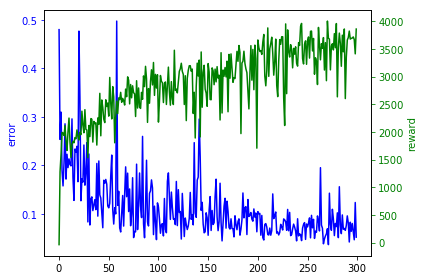

In [8]:

import matplotlib.pyplot as plt
%matplotlib inline

fig, ax1 = plt.subplots()
ax1.plot([e[1] for e in results], 'b-')
#ax1.set_xlabel('time (s)')
ax1.set_ylabel('error', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot([e[2] for e in results], 'g')
ax2.set_ylabel('reward', color='g')
ax2.tick_params('y', colors='g')

fig.tight_layout()
plt.show()


In [11]:
print('''Behavarial cloning for {}.
Expert  policy mean reward {:.2f} and std {:.3f}.
Learned policy mean reward {:.2f} and std {:.3f}.'''.format(
    envname, 
    np.mean([e[0] for e in results][-100:]),
    np.std([e[0] for e in results][-100:]),
    np.mean([e[2] for e in results][-100:]),
    np.std([e[2] for e in results][-100:])
))

Behavarial cloning for HalfCheetah-v1.
Expert  policy mean reward 4138.91 and std 59.759.
Learned policy mean reward 3456.92 and std 353.389.


In [13]:
args = pd.Series({
        'expert_policy_file':'experts/' + envname + '.pkl',
        'envname': envname,
        'max_timesteps': None,
        'num_rollouts':1,
        'render': True
    })
learn_imitatation_learning(ffn, args)
#evaluate_imitation_learning(ffn, args)

loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 23:53:39,280] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 23:53:39,293] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 23:53:42,196] Making new env: HalfCheetah-v1


KeyboardInterrupt: 